In [1]:
import cmdstanpy
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from cmdstanpy import cmdstan_path, CmdStanModel

from sklearn.metrics import mean_squared_error
from math import sqrt

from tqdm import tqdm
import logging, sys
logging.disable(sys.maxsize)

In [2]:
!export CMDSTAN='/Users/meenaljhajharia/cmdstan'

In [3]:
az.style.use("arviz-darkgrid")

In [4]:
file='/Users/meenaljhajharia/cmdstan/transforms/simplex-stan/simplex-stan.stan'
alpha=1
K=10
iters=1000

model = CmdStanModel(stan_file=file, cpp_options={'STAN_THREADS':'true'})

alpha = np.repeat(alpha,K)
true = np.repeat(np.asarray(alpha/np.sum(alpha))[0], iters)

fit = model.sample(data=dict(K=K,alpha=alpha),show_progress=False, chains=1, iter_sampling=iters)

dataframe_draws = fit.draws_pd()

pred = np.asarray(dataframe_draws[['x[1]']])

leapfrog = dataframe_draws[['n_leapfrog__']].values

In [5]:
def get_rmse_leapfrog(file, alpha, K, iters, return_idata=False):
    model = CmdStanModel(stan_file=file, cpp_options={'STAN_THREADS':'true'})
    
    alpha = np.repeat(alpha,K)
    true = np.repeat(np.asarray(alpha/np.sum(alpha))[0], iters)
    
    fit = model.sample(data=dict(K=K,alpha=alpha),show_progress=False, chains=1, iter_sampling=iters)
    
    dataframe_draws = fit.draws_pd()
    
    pred = np.asarray(dataframe_draws[['x[1]']])
    leapfrog = dataframe_draws[['n_leapfrog__']].values

    y=[]
    for i in range(1, iters+1):
            y.append(mean_squared_error(true[:i], pred[:i]))

    x = np.cumsum(leapfrog)
    
    return x,y

In [6]:
def repeat(file, alpha, K, iters, N=100):
    x=np.empty([N, iters])
    y=np.empty([N, iters])
    for i in range(N):
        a,b=get_rmse_leapfrog(file, alpha=alpha, K=K, iters=iters)
        x[i] = a
        y[i] = b
    x_mean = x.mean(axis=0)
    y_mean = y.mean(axis=0)
    return x_mean, y_mean

In [7]:
def get_plot(ax,alpha,N,K,iters):
    
    file_simplex_stan = '/Users/meenaljhajharia/cmdstan/transforms/simplex-stan/simplex-stan.stan'
    file_simplex_stickbreaking = '/Users/meenaljhajharia/cmdstan/transforms/simplex-stickbreaking/simplex-stickbreaking.stan'
    file_simplex_softmax = '/Users/meenaljhajharia/cmdstan/transforms/simplex-softmax/simplex-softmax.stan'
    file_simplex_softmax_augmented = '/Users/meenaljhajharia/cmdstan/transforms/simplex-softmax-augmented/simplex-softmax-augmented.stan'

    x_simplex_stan, y_simplex_stan = repeat(file_simplex_stan, alpha=alpha, K=K, N=N, iters=iters)
    x_simplex_stickbreaking, y_simplex_stickbreaking = repeat(file_simplex_stickbreaking, alpha=alpha, K=K, N=N, iters=iters)
    x_simplex_softmax, y_simplex_softmax = repeat(file_simplex_softmax, alpha=alpha, K=K, N=N, iters=iters)
    x_simplex_softmax_augmented, y_simplex_softmax_augmented = repeat(file_simplex_softmax_augmented, 
                                                                      alpha=alpha, K=K, N=N, iters=iters)

    ax.plot(x_simplex_stan, y_simplex_stan, label = "Stan Transform")
    ax.plot(x_simplex_stickbreaking, y_simplex_stickbreaking, label = "Stickbreaking")
    ax.plot(x_simplex_softmax, y_simplex_softmax, label = "Softmax")
    ax.plot(x_simplex_softmax_augmented, y_simplex_softmax_augmented, label = "Softmax Augmented")
    
    ax.set_title('alpha='+str(alpha)+', K='+str(K))

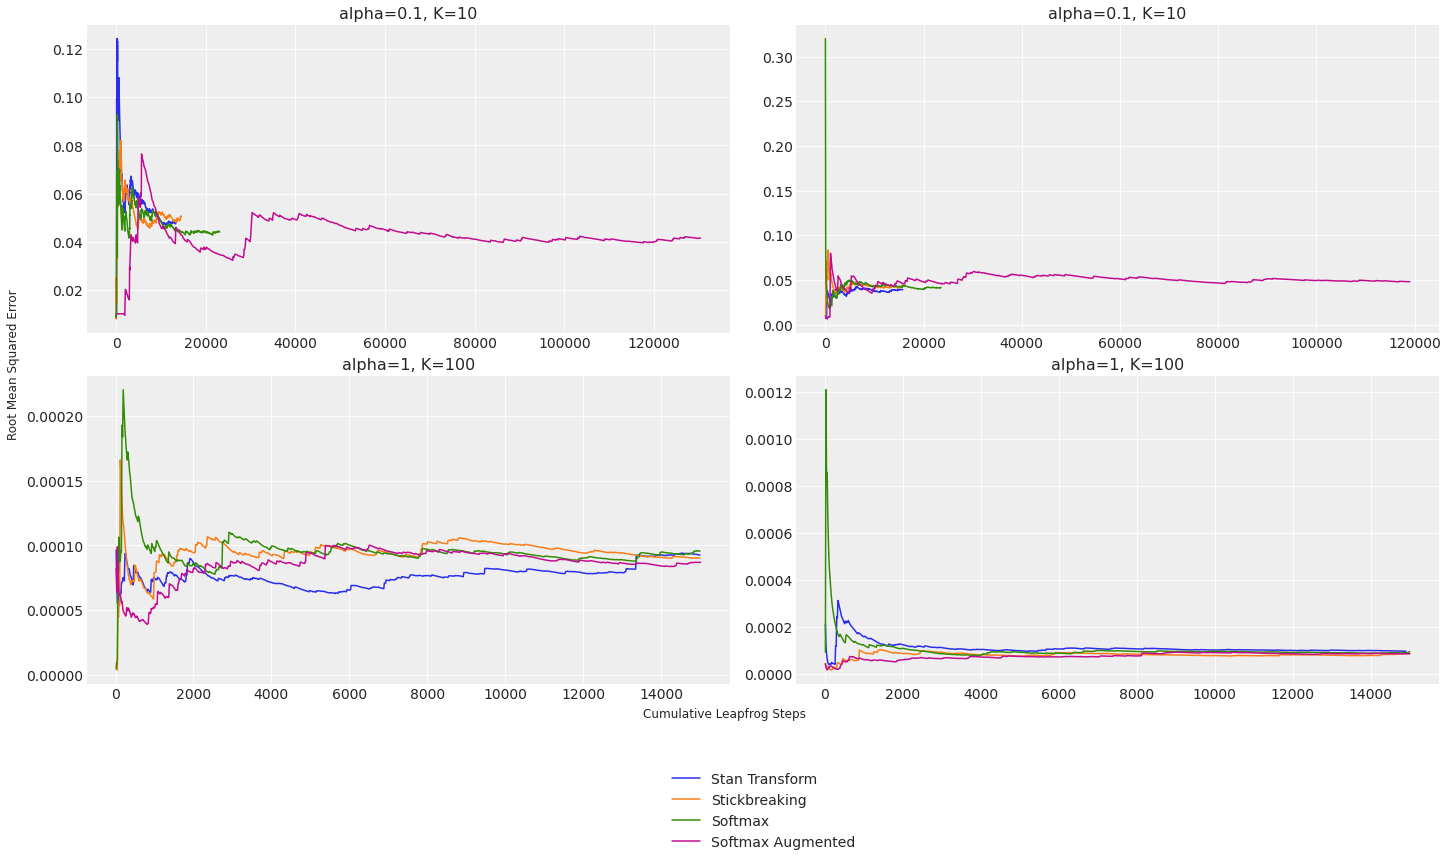

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(2,2)
fig.supxlabel('Cumulative Leapfrog Steps')
fig.supylabel('Root Mean Squared Error')
fig.legend(labels=["Stan Transform", "Stickbreaking", "Softmax", "Augmented Softmax"],bbox_to_anchor = (0.6, -0.05));

get_plot(axes[0,0],alpha=0.1,N=1,K=10,iters=1000)
get_plot(axes[1,0],alpha=1,N=1,K=100,iters=1000)
get_plot(axes[0,1],alpha=0.1,N=1,K=10,iters=1000)
get_plot(axes[1,1],alpha=1,N=1,K=100,iters=1000)
fig.legend(labels=["Stan Transform","Stickbreaking","Softmax","Softmax Augmented"],bbox_to_anchor = (0.6, -0.05));